In [1]:
!pip install pettingzoo[atari]==1.23.1
!pip install multi-agent-ale-py==0.1.14
!pip install "protobuf<4" "tensorboard<2.13"
!pip install supersuit
!pip install stable-baselines3
!pip install swig
!apt-get install cmake gcc g++ -y

!pip install "autorom[accept-rom-license"]
!AutoROM --accept-license

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.0/552.0 kB 10.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.7/826.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.5 MB/s eta 0:00:00:00:0100:01
  Created wheel for multi-agent-ale-py: filename=multi_agent_ale_py-0.1.11-cp311-cp311-linux_x86_64.whl size=721821 sha256=28946337e04a8cf6916fbc77150f10a0ebe0e8deb470a4e09416fd67b5bdc1b2
  Stored in directory: /root/.cache/pip/wheels/1d/81/76/771ec8e34292c8a71dd6c4a52a1c0401f4d93cbfb54e02fce4
Successfully built multi-agent-ale-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1
  Attempting uninstall: pettingzoo
    Found existing installation: pettingzoo 1.24.0
    Uninstalling pettingzoo-1.24.0:
      Successfully uninstalled pettingzoo-1.24.0
ERROR: pip's dependency resolver does not 

In [2]:
import numpy as np
import random
import supersuit as ss
from pettingzoo.atari import pong_v3
import gymnasium as gym
import torch
from gymnasium import spaces
import torch.nn as nn
import torch.nn.functional as F
import imageio
from stable_baselines3 import PPO
import stable_baselines3

MAX_INT = int(10e6)
TIME_STEP_MAX = 100000

def get_seed(MAX_INT=int(10e6)):
    return random.randint(0, MAX_INT)

def make_env(render_mode="rgb_array"):
    env = pong_v3.env(num_players=2, render_mode=render_mode)

    env = ss.sticky_actions_v0(env, repeat_action_probability=0.25)
    env = ss.color_reduction_v0(env, mode="B")
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.frame_stack_v1(env, 4, stack_dim=0)
    env = ss.dtype_v0(env, dtype=np.uint8)
    env = ss.reshape_v0(env, (4, 84, 84))

    env.reset(seed=get_seed(MAX_INT))
    env.action_space(env.possible_agents[0]).seed(get_seed(MAX_INT))

    return env

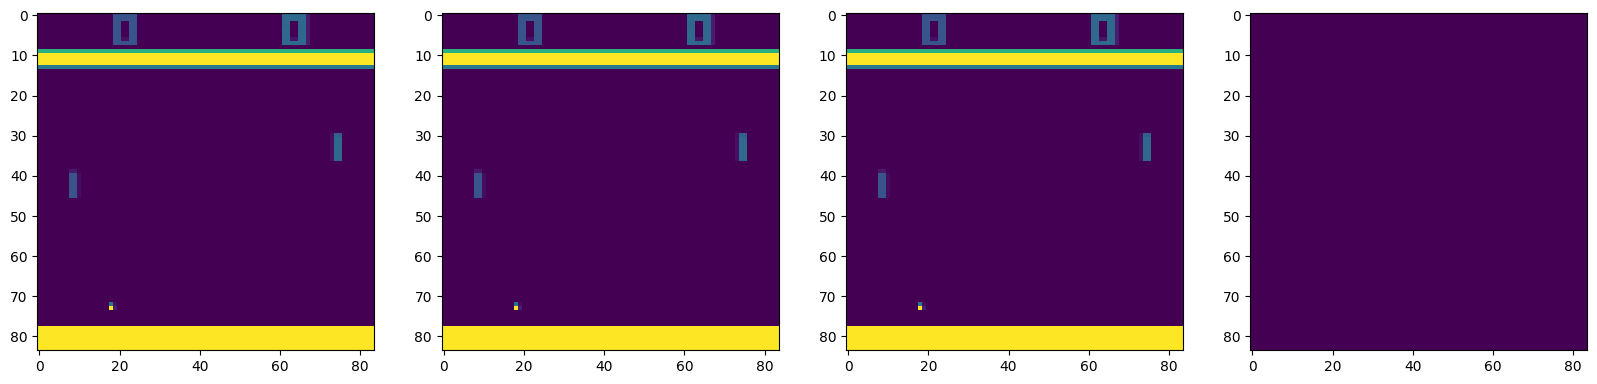

In [44]:
def make_env(render_mode="rgb_array"):
    env = pong_v3.env(num_players=2, render_mode=render_mode)

    env = ss.color_reduction_v0(env, mode="B")
    env = ss.resize_v1(env, x_size=84, y_size=84)
    env = ss.frame_stack_v1(env, 4, stack_dim=0)
    env = ss.dtype_v0(env, dtype=np.float32)
    env = ss.normalize_obs_v0(env, env_min=0, env_max=1)
    env = ss.reshape_v0(env, (4, 84, 84))

    env.reset(seed=get_seed(MAX_INT))
    env.action_space(env.possible_agents[0]).seed(get_seed(MAX_INT))

    return env

temp_env = make_env()
temp_env.reset()

import matplotlib.pyplot as plt

# plot this
env = make_env()
env.reset()
for agent in env.agent_iter(200):
    action = env.action_space(agent).sample()
    env.step(action)

obs = env.last()[0]
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
	ax[i].imshow(obs[i])
plt.show()


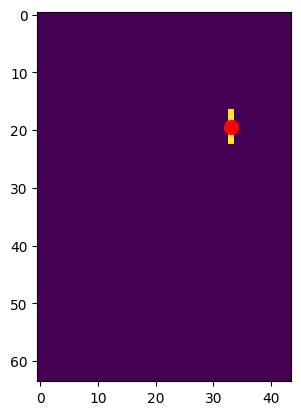

In [66]:
player_id = "first_0"
y_min, y_max = 14, 78
x_threshold = 40
if player_id == "second_0": # left player
	obs_crop = obs[0][y_min:y_max, :x_threshold]
else: # right player
	obs_crop = obs[0][y_min:y_max, x_threshold:]
obs_crop = (obs_crop > 0.1) & (obs_crop < 0.3)
center_of_mass = np.argwhere(obs_crop)
center_of_mass = np.mean(center_of_mass, axis=0)
# center_of_mass[0] += y_min
# if player_id == "first_0":
# 	center_of_mass[1] += x_threshold

plt.imshow(obs_crop)
plt.scatter(center_of_mass[1], center_of_mass[0], color='red', s=100)

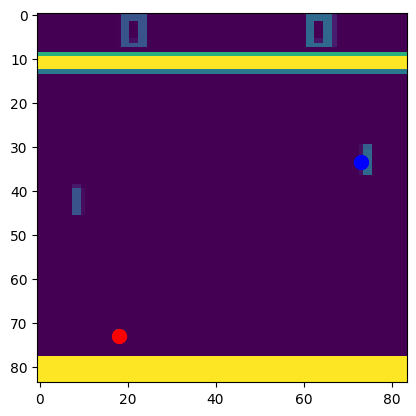

In [53]:
def find_ball(obs):
	y_min, y_max = 14, 78
	obs_crop = obs[y_min:y_max, :]
	obs_crop = obs_crop > 0.5
	# get center of mass
	center_of_mass = np.argwhere(obs_crop)
	center_of_mass = np.mean(center_of_mass, axis=0)
	center_of_mass[0] += y_min
	# if is nan, return None
	if np.isnan(center_of_mass).any():
		return (None, None)
	return center_of_mass

def get_agent_position(obs, player_id):
	assert player_id in ["first_0", "second_0"]
	y_min, y_max = 14, 78
	x_threshold = 40
	if player_id == "second_0": # left player
		obs_crop = obs[y_min:y_max, :x_threshold]
	else: # right player
		obs_crop = obs[y_min:y_max, x_threshold:]
	obs_crop = (obs_crop > 0.1) & (obs_crop < 0.3)
	center_of_mass = np.argwhere(obs_crop)
	center_of_mass = np.mean(center_of_mass, axis=0)
	center_of_mass[0] += y_min
	if player_id == "first_0":
		center_of_mass[1] += x_threshold
	if np.isnan(center_of_mass).any():
		return (None, None)
	return center_of_mass

plt.imshow(obs[0])
# draw a circle at the center of mass
ball_y, ball_x = find_ball(obs[0])
agent_y, agent_x = get_agent_position(obs[0], "first_0")
plt.scatter(ball_x, ball_y, color='red', s=100)
plt.scatter(agent_x, agent_y, color='blue', s=100)
plt.show()

In [18]:
env.reset()

In [21]:
m = 10
i = 0

for agent in env.agent_iter():
	obs, reward, terminated, truncated, info = env.last()
	env.step(0)
	print(agent)
	i += 1
	if i == m:
		break

first_0
second_0
first_0
second_0
first_0
second_0
first_0
second_0
first_0
second_0


In [22]:
env.agents, env.possible_agents

(['first_0', 'second_0'], ['first_0', 'second_0'])

In [23]:
env.rewards

{'first_0': 0, 'second_0': 0}

In [9]:
for i in env.agent_iter():
	env.last()
	print(i)
	env.step(0)

AssertionError: need to call step() or reset() in a loop over `agent_iter`

In [52]:
obs.shape

(84, 84, 4)

In [49]:
env.last()[1:]

(0, False, False, {})

In [3]:
class PZSingleAgentWrapper(gym.Env):
    metadata = {"render_modes": ["rgb_array", "human"]}

    def __init__(self, player_id, opponent_model, render_mode=None):
        super().__init__()

        self.player_id = player_id
        self.opponent_id = "second_0" if player_id == "first_0" else "first_0"

        # Inicializa el entorno
        self.env = make_env(render_mode=render_mode)

        # Observación de ejemplo
        example_obs = self.env.observe(self.player_id)

        # Space debe ser uint8 para CnnPolicy
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=example_obs.shape,
            dtype=np.uint8
        )

        # Espacio de acciones del agente
        self.action_space = self.env.action_space(self.player_id)

        self.opponent_model = opponent_model

        self.agent_iter = None  # Guardaremos el iterador

    def reset(self, *, seed=None, options=None):
        self.env.reset(seed=seed)
        self.agent_iter = iter(self.env.agent_iter())
    
        obs_agent = None
        while True:
            agent = next(self.agent_iter)
            obs, reward, terminated, truncated, info = self.env.last()
    
            if agent == self.player_id:
                obs_agent = obs
                self.env.step(0)
                break
    
            elif isinstance(self.opponent_model, DQN):
                with torch.no_grad():
                    t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0) / 255.0
                    act = self.opponent_model(t).argmax().item()

            else:
                act, _ = self.opponent_model.predict(obs, deterministic=True)

            self.env.step(act)

        return obs_agent, {}

    def step(self, action):
        obs_agent, reward_agent, done = None, 0, False

        while True:
            agent = next(self.agent_iter)
            obs, reward, terminated, truncated, info = self.env.last()
    
            if agent == self.player_id:
                obs_agent = obs
                reward_agent = reward
                done = terminated or truncated
                self.env.step(0)
                break
    
            elif isinstance(self.opponent_model, DQN):
                with torch.no_grad():
                    t = torch.tensor(obs, dtype=torch.float32).unsqueeze(0) / 255.0
                    act = self.opponent_model(t).argmax().item()

            else:
                act, _ = self.opponent_model.predict(obs, deterministic=True)

            self.env.step(act)

        return obs_agent, reward_agent, done, False, {}

    def render(self):
        return self.env.render()

    def close(self):
        self.env.close()

In [4]:
class DQN(nn.Module):
    def __init__(self, in_channels, n_actions):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.out = nn.Linear(512, n_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.out(x)

opponent_model = DQN(4, 6)
opponent_model.load_state_dict(torch.load('/kaggle/input/dqn-opponent/checkpoint_best.pth')["policy_state_dict"])

<All keys matched successfully>

In [5]:
def record_match(left_model, right_model, filename="match.gif", max_steps=3000):
    """
    Simula un partido entre left_model y right_model y lo guarda como GIF.
    """
    env = make_env(render_mode="rgb_array")
    env.reset()

    agent_iter = iter(env.agent_iter())

    frames = []

    # Inicializar observaciones
    obs_left = env.observe("second_0")
    obs_right = env.observe("first_0")

    done = False
    step = 0

    while not done and step < max_steps:

        # Acciones para cada agente
        with torch.no_grad():
            act_left = left_model.predict(obs_left, deterministic=True)[0]
            act_right = right_model.predict(obs_right, deterministic=True)[0]

        # SOLO un paso del agente actual
        agent = next(agent_iter)
        obs, reward, termination, truncation, info = env.last()

        if agent == "second_0":
            env.step(act_left)
            obs_left = obs

        elif agent == "first_0":
            env.step(act_right)
            obs_right = obs

        else:
            env.step(env.action_space(agent).sample())

        done = termination or truncation

        # Capturar frame
        frame = env.render()
        frames.append(frame)

        step += 1

    env.close()
    imageio.mimsave(filename, frames, fps=30)

In [6]:
env_left = PZSingleAgentWrapper(player_id="second_0", opponent_model=opponent_model)

print("LEFT vs DQN")

model_left = PPO("CnnPolicy", env_left, verbose=1)
model_left.learn(total_timesteps=300_000, progress_bar = True, log_interval=25)
model_left.save("left1.zip")

left_frozen = PPO.load("left1.zip")

env_right = PZSingleAgentWrapper(player_id="first_0", opponent_model=left_frozen)

print("RIGHT vs LEFT")
model_right = PPO("CnnPolicy", env_right, verbose=1)
model_right.learn(total_timesteps=300_000, progress_bar = True, log_interval=25)
model_right.save("right1.zip")

LEFT vs DQN
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

-----------------------------------------
| time/                   |             |
|    fps                  | 174         |
|    iterations           | 25          |
|    time_elapsed         | 292         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.016444655 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0286     |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00562    |
|    value_loss           | 1.54e-08    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+05       |
|    ep_rew_mean          | 3           |
| time/                   |             |
|    fps                  | 174   

Output()

RIGHT vs LEFT
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------------
| time/                   |              |
|    fps                  | 176          |
|    iterations           | 25           |
|    time_elapsed         | 289          |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0065620043 |
|    clip_fraction        | 0.0519       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.6         |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0304       |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00342     |
|    value_loss           | 0.0536       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+05

In [ ]:
left_model = PPO.load("left1.zip")
right_model = PPO.load("right1.zip")

print(f"=== PRE-TRAIN: GENERANDO GIF ===")
record_match(left_model, right_model, filename=f"match_iter_0.gif")

for i in range(10):
    print(f"=== CICLO {i}: ENTRENANDO LEFT ===")
    
    env_left = PZSingleAgentWrapper("second_0", opponent_model=right_model)
    left_model.set_env(env_left)
    left_model.learn(100000, log_interval=30, reset_num_timesteps=False)
    left_model.save(f"left_iter_{i}.zip")

    print(f"=== CICLO {i}: ENTRENANDO RIGHT ===")
    
    env_right = PZSingleAgentWrapper("first_0", opponent_model=left_model)
    right_model.set_env(env_right)
    right_model.learn(100000, log_interval=30, reset_num_timesteps=False)
    right_model.save(f"right_iter_{i}.zip")

    print(f"=== CICLO {i}: GENERANDO GIF ===")
    record_match(left_model, right_model, filename=f"match_iter_{i+1}.gif")


=== PRE-TRAIN: GENERANDO GIF ===


/usr/local/lib/python3.11/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


=== CICLO 0: ENTRENANDO LEFT ===
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
